In [3]:
import numpy as np

In [4]:
import numpy as np
import math

INIMUM_MSE_GRID = [[ -0.798, 0.798 ],
        [ -1.493, 1.493 ],
        [ -2.051, 2.051 ],
        [ -2.514, 2.514 ],
        [ -2.916, 2.916 ],
        [ -3.278, 3.278 ],
        [ -3.611, 3.611 ],
        [ -3.922, 3.922 ]]

class Optimizer:

    def __init__(self, vector, nbits):
        self.vector = vector
        self.points = 1 << nbits
        std = np.std(vector)
        mean = np.mean(vector)
        min_ = np.min(vector)
        max_ = np.max(vector)
        self.interval = [
            np.clip((INIMUM_MSE_GRID[nbits - 1][0] + mean) * std, min_, max_), 
            np.clip((INIMUM_MSE_GRID[nbits - 1][1] + mean) * std, min_, max_)
        ]
        self.norm2 = np.linalg.norm(vector) ** 2
        self.lambda_ = 0.1
        self.loss_ = self.loss()
    
    def optimize(self, steps):
        for i in range(steps):
            new_interval = self.inner_step()
            new_loss = self.loss(new_interval)
            if new_loss > self.loss_:
                print(f"Converged at step {i} loss {new_loss}")
                break
            if math.isclose(self.interval[0], new_interval[0]) or math.isclose(self.interval[1], new_interval[1]):
                print(f"Converged at step {i} loss {new_interval}")
                break
            self.interval = new_interval
            self.loss_ = self.loss()
            print(f"Step {i}: {self.interval} {self.loss_}")
        return self.quantized()
    
    def inner_step(self):
        a = self.interval[0]
        b = self.interval[1]
        scale = (1.0 - self.lambda_) / self.norm2
        stepInv = (self.points - 1.0) / (b - a)

        daa = 0.0
        dab = 0.0
        dbb = 0.0
        dax = 0.0
        dbx = 0.0
        mxx = 0.0
        for i in range(len(self.vector)):
            xi = self.vector[i]
            k = round((np.clip(xi, a, b) - a) * stepInv)
            s = k / (self.points - 1)
            daa += (1.0 - s) * (1.0 - s)
            dab += (1.0 - s) * s
            dbb += s * s
            dax += xi * (1.0 - s)
            dbx += xi * s
            mxx += xi * xi

        M = [
            scale * dax * dax + self.lambda_ * daa,
            scale * dax * dbx + self.lambda_ * dab,
            scale * dbx * dbx + self.lambda_ * dbb
        ]
        c = [dax, dbx]

        det = M[0] * M[2] - M[1] * M[1]

        if det == 0.0:
            return self.interval

        aOpt = (M[2] * c[0] - M[1] * c[1]) / det
        bOpt = (M[0] * c[1] - M[1] * c[0]) / det
        return [aOpt, bOpt]

    def loss(self, interval=None):
        if interval is None:
            interval = self.interval
        a = interval[0]
        b = interval[1]
        step = ((b - a) / (self.points - 1.0))
        stepInv = 1.0 / step
        xe = 0.0
        e = 0.0
        for xi in self.vector:
            xiq = (a + step * round((np.clip(xi, a, b) - a) * stepInv))
            xe += xi * (xi - xiq)
            e += (xi - xiq) * (xi - xiq)
        return (1.0 - self.lambda_) * xe * xe / self.norm2 + self.lambda_ * e

    def component_errors(self):
        a = self.interval[0]
        b = self.interval[1]
        step = ((b - a) / (self.points - 1.0))
        stepInv = 1.0 / step
        error = []
        for xi in self.vector:
            xiq = (a + step * round((np.clip(xi, a, b) - a) * stepInv))
            error.append(math.sqrt((xi - xiq) * (xi - xiq)))
        error = np.array(error)
        return error 

    def quantized(self):
        a = self.interval[0]
        b = self.interval[1]
        step = ((b - a) / (self.points - 1.0))
        return [round((np.clip(xi, a, b) - a) / step) for xi in self.vector]


In [5]:
# read vectors from a single 384 dimensional float32 vector from binary file data/queries-wiki-cohere.fvec.flat
# it as written via np.array.tofile
with open("data/queries-wiki-cohere.fvec.flat", "rb") as f:
    vectors = np.fromfile(f, dtype=np.float32, count=-1)
vectors = vectors.reshape(-1, 384)
centroid = np.mean(vectors, axis=0) 
centered_vectors = vectors - centroid

Step 9: [-0.8913533089935889, 0.8526232711488102] 3.339833405458148
Step 1: [-1.0235417656489185, 0.9682689325614393] 3.303164483661262
Step 2: [-1.1494544150571209, 1.0894665784794242] 2.985738738544006
Step 3: [-1.2435020902888394, 1.1716825375949182] 3.098308700652032
Step 4: [-1.3303164096392162, 1.2457782150991994] 2.976815163333331
Step 5: [-1.3692882920125242, 1.2781898991038771] 2.978593678707822
Step 6: [-1.3851683677883044, 1.2886477395926759] 2.978741802252293
Step 7: [-1.3939098086457895, 1.283338862319125] 2.984446114307003
Step 8: [-1.4029263668288643, 1.2782506128560325] 3.054359460126247
Step 9: [-1.4262493145294193, 1.2861407571358334] 3.0563747681832965


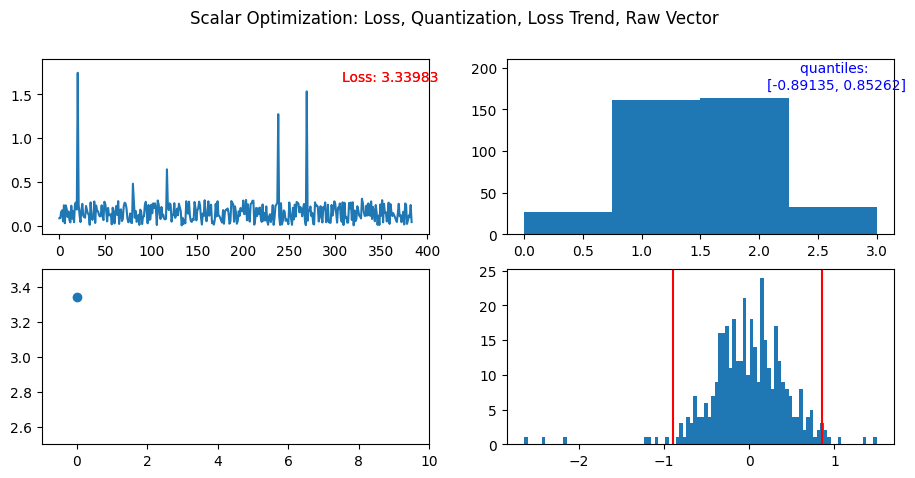

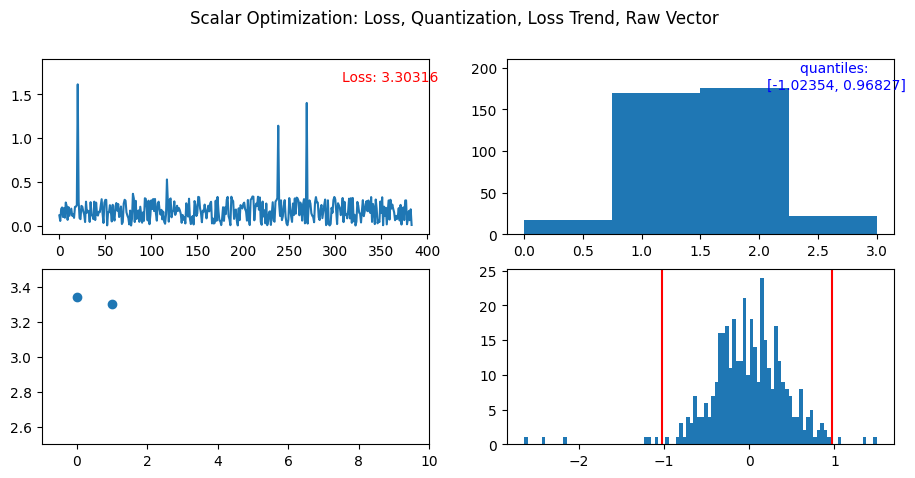

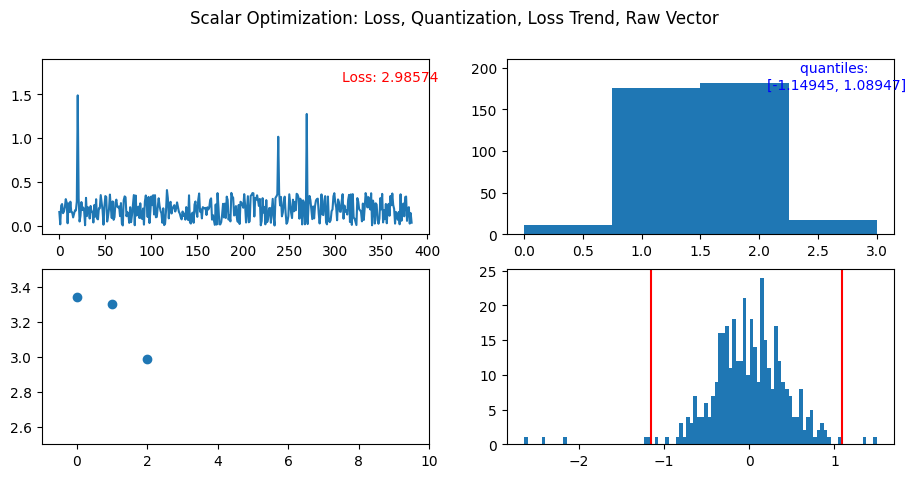

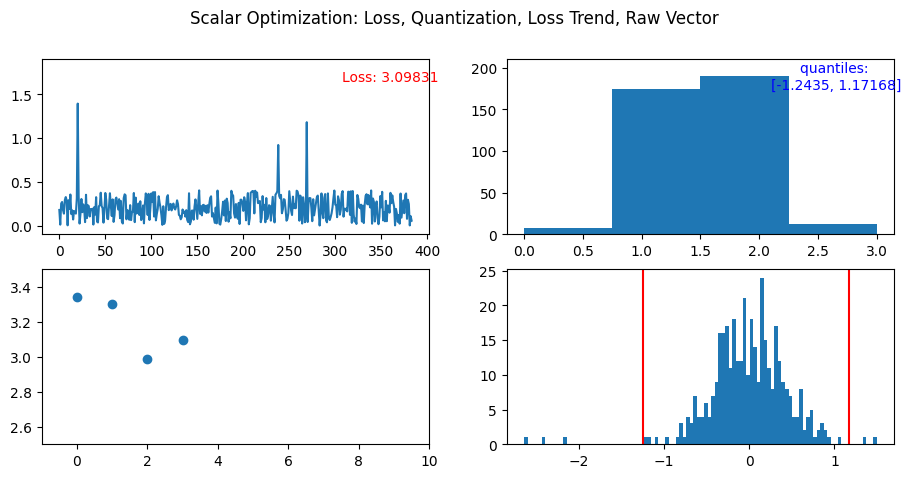

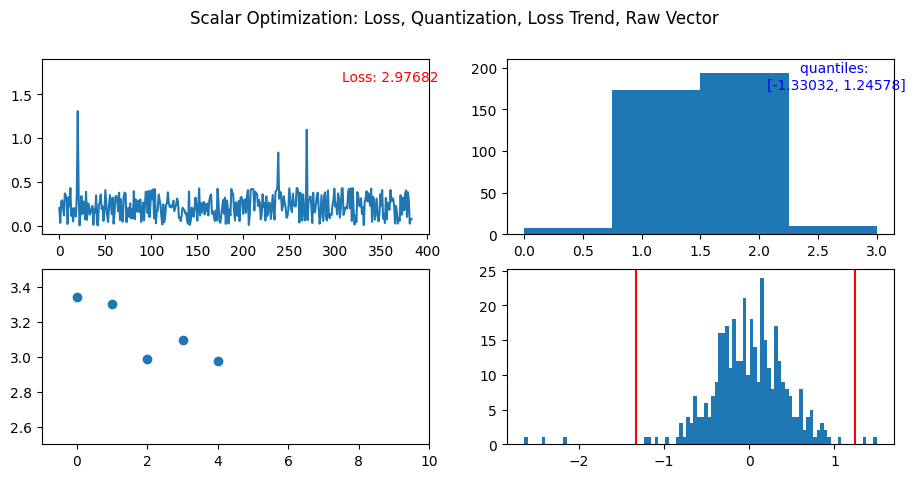

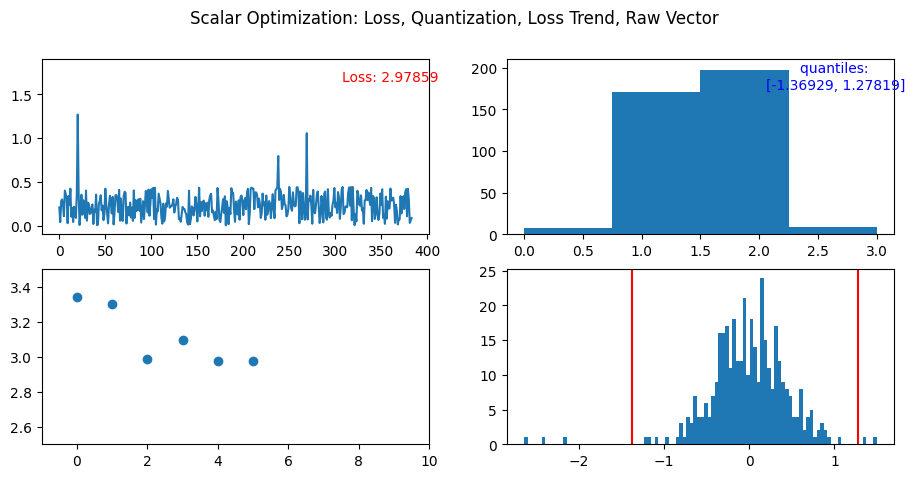

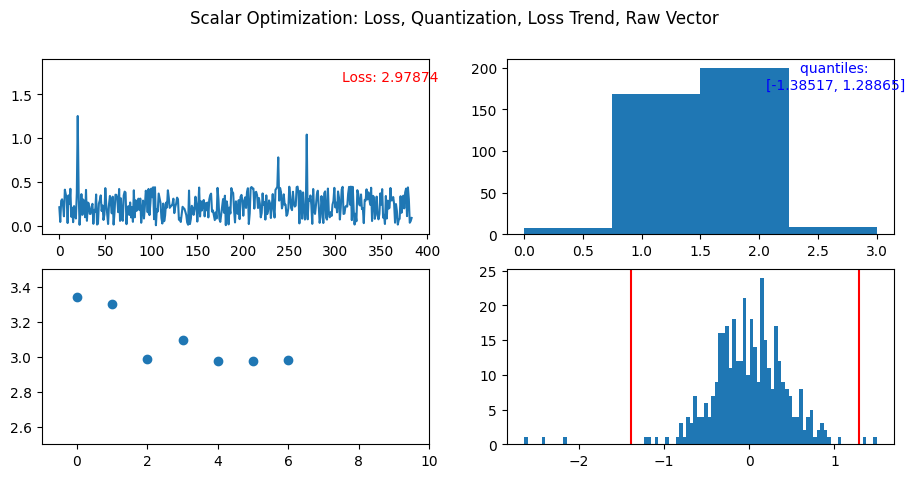

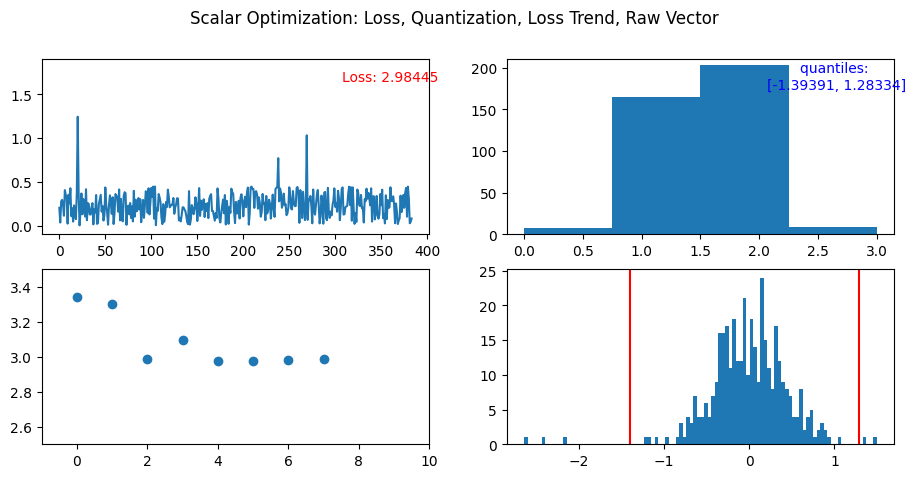

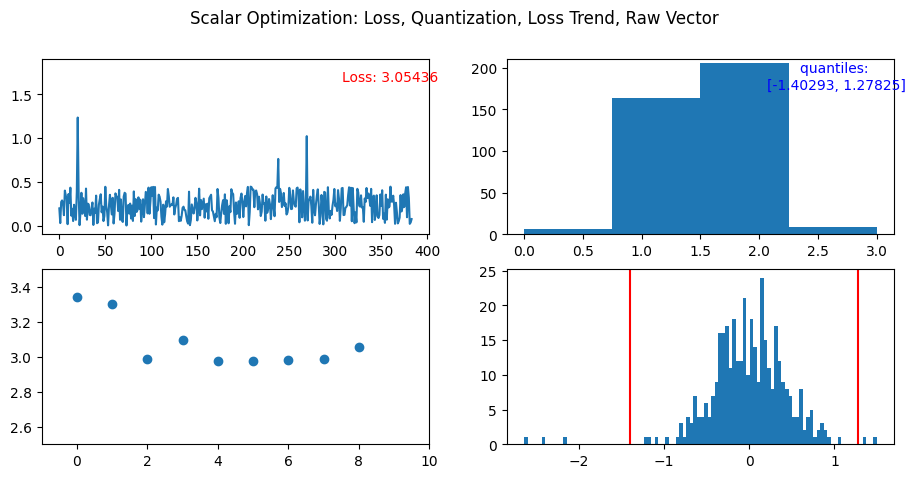

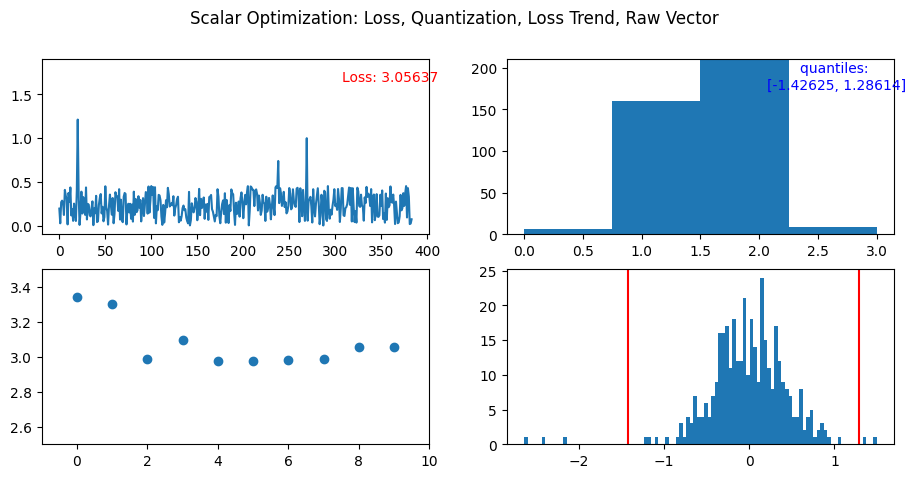

In [57]:
import matplotlib.pyplot as plt
optimizer = Optimizer(centered_vectors[0], 2)
interval = optimizer.interval

# have both plots in the same image side by side as subplots
interval = optimizer.inner_step()
optimizer.interval = interval
print(f"Step {i}: {interval} {optimizer.loss()}")
losses = [optimizer.loss()]
# have both plots in the same image side by side as subplots
fig, axs = plt.subplots(2, 2)
axs[0][0].plot(optimizer.component_errors())
axs[0][0].set_ylim(-0.1, 1.9)
axs[0][0].text(0.9, 0.9, f"Loss: {round(optimizer.loss(), 5)}", horizontalalignment='center', verticalalignment='center', transform=axs[0][0].transAxes, color='red')
axs[0][1].hist(optimizer.quantized(), bins=(1<<2))
axs[0][1].set_ylim(0, 210)
axs[0][0].text(0.9, 0.9, f"Loss: {round(optimizer.loss(), 5)}", horizontalalignment='center', verticalalignment='center', transform=axs[0][0].transAxes, color='red')
axs[0][1].text(0.85, 0.9, f"quantiles: \n[{round(interval[0], 5)}, {round(interval[1], 5)}]", horizontalalignment='center', verticalalignment='center', transform=axs[0][1].transAxes, color='blue')
# add a third dot-plot showing the losses trend
# ensure the axis starts at `0` for the x-axis
axs[1][0].set_xlim(-1, 10)
axs[1][0].set_ylim(2.5, 3.5)
axs[1][0].plot(losses, 'o')
# add a fourth plot of the raw vector, but with vertical lines at the interval values
axs[1][1].hist(centered_vectors[0], bins=100)
axs[1][1].axvline(x=interval[0], color='red')
axs[1][1].axvline(x=interval[1], color='red')
fig.set_size_inches(11, 5)
# add overall title
fig.suptitle("Scalar Optimization: Loss, Quantization, Loss Trend, Raw Vector")
plt.savefig(f"osq_{1:02d}.png")

losses = [optimizer.loss()]
for i in range(1, 10):
    interval = optimizer.inner_step()
    optimizer.interval = interval
    print(f"Step {i}: {interval} {optimizer.loss()}")
    losses.append(optimizer.loss())
    # have both plots in the same image side by side as subplots
    fig, axs = plt.subplots(2, 2)
    axs[0][0].plot(optimizer.component_errors())
    axs[0][0].text(0.9, 0.9, f"Loss: {round(optimizer.loss(), 5)}", horizontalalignment='center', verticalalignment='center', transform=axs[0][0].transAxes, color='red')
    axs[0][0].set_ylim(-0.1, 1.9)
    axs[0][1].hist(optimizer.quantized(), bins=(1<<2))
    axs[0][1].set_ylim(0, 210)
    axs[0][1].text(0.85, 0.9, f"quantiles: \n[{round(interval[0], 5)}, {round(interval[1], 5)}]", horizontalalignment='center', verticalalignment='center', transform=axs[0][1].transAxes, color='blue')
    axs[1][0].set_xlim(-1, 10)
    axs[1][0].set_ylim(2.5, 3.5)
    axs[1][0].plot(losses, 'o')
    axs[1][1].hist(centered_vectors[0], bins=100)
    axs[1][1].axvline(x=interval[0], color='red')
    axs[1][1].axvline(x=interval[1], color='red')
    # make the plots bigger
    fig.set_size_inches(11, 5)
    fig.suptitle("Scalar Optimization: Loss, Quantization, Loss Trend, Raw Vector")
    plt.savefig(f"osq_{i+1:02d}.png")


In [136]:
optimizer = Optimizer(centered_vectors[0], 2)
quantized = optimizer.quantized()
print(quantized)
l = (int)(len(quantized) // 2)
print(np.convolve(quantized, np.ones(l)/l, "valid").shape)
print(l)

[2, 2, 2, 2, 1, 3, 3, 2, 2, 2, 1, 1, 3, 3, 2, 2, 1, 3, 0, 1, 0, 2, 2, 2, 1, 3, 1, 2, 1, 1, 3, 2, 2, 2, 0, 2, 1, 2, 3, 2, 2, 0, 0, 2, 1, 3, 0, 2, 2, 0, 1, 0, 1, 0, 2, 3, 2, 2, 2, 2, 2, 1, 2, 1, 3, 3, 3, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 2, 2, 1, 3, 1, 1, 3, 2, 2, 1, 1, 2, 2, 1, 1, 1, 3, 2, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1, 3, 2, 1, 1, 3, 2, 2, 2, 1, 1, 3, 1, 0, 3, 3, 1, 2, 1, 0, 2, 2, 2, 1, 0, 3, 2, 2, 2, 1, 2, 1, 0, 2, 2, 2, 2, 2, 1, 2, 1, 3, 2, 1, 2, 0, 1, 3, 1, 1, 2, 1, 0, 2, 2, 2, 0, 1, 2, 2, 1, 2, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 0, 3, 0, 2, 1, 1, 1, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2, 1, 2, 0, 0, 1, 0, 3, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 3, 0, 1, 3, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 3, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 2, 1, 1, 2, 2, 1, 2, 1, 1, 3, 2, 1, 0, 2, 2, 3, 2, 2, 2, 3, 1, 0, 3, 2, 1, 1, 2, 3, 3, 1, 0, 1, 2, 2, 2, 1, 1, 2, 1, 3, 2, 3, 1, 3, 2, 1, 1, 2, 0, 2, 3, 1, 2, 0, 2, 2, 1, 0, 1, 3, 1, 2, 1, 1, 0, 1, 2, 1, 1, 2, 2, 3, 0, 3, 0, 1, 

In [145]:
%%manim -qm VisualizeOptimizer

optimizer = Optimizer(centered_vectors[0], 2)

class VisualizeOptimizer(Scene):
    def step(self):
        pass

    def construct(self):
        buckets = (int)(len(centered_vectors[0]) // 2)
        quantized = optimizer.quantized()
        chart = BarChart(
            values=np.convolve(quantized, np.ones(buckets) / buckets, mode='valid'),
            axis_config={"include_ticks": False, "include_numbers": False, "include_tip": False},
            tips=False,
            bar_colors=[BLUE],
        )
        component_errors = optimizer.component_errors() 
        # smooth out the component errors to make the line graph look better
        component_errors = np.convolve(component_errors, np.ones(buckets) / buckets, mode='valid')
        line_x_values = list(range(len(component_errors)))
        line_graph = chart.plot_line_graph(x_values = line_x_values, y_values = component_errors, line_color=RED_A, add_vertex_dots=False)
        self.play(Create(chart), run_time=2)
        self.play(Create(line_graph), run_time=2)
        self.wait(1)
        for i in range(5):
            interval = optimizer.inner_step()
            optimizer.interval = interval
            quantized = optimizer.quantized()
            new_chart = BarChart(
                values=np.convolve(quantized, np.ones(buckets) / buckets, mode='valid'),
                axis_config={"include_ticks": False, "include_numbers": False, "include_tip": False},
                tips=False,
                bar_colors=[BLUE],
            )
            component_errors = np.convolve(optimizer.component_errors(), np.ones(buckets) / buckets, mode='valid')
            new_line_graph = chart.plot_line_graph(x_values = line_x_values, y_values = component_errors, line_color=RED_A, add_vertex_dots=False)
            self.play(Transform(chart, new_chart), run_time=2)
            self.play(Transform(line_graph, new_line_graph), run_time=2)
            line_graph = new_line_graph
            chart = new_chart
            self.wait(1)
        


Manim Community v0.18.1